# King County Housing Analysis

---

**Import Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#read data
df = pd.read_csv('data/kingcounty.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


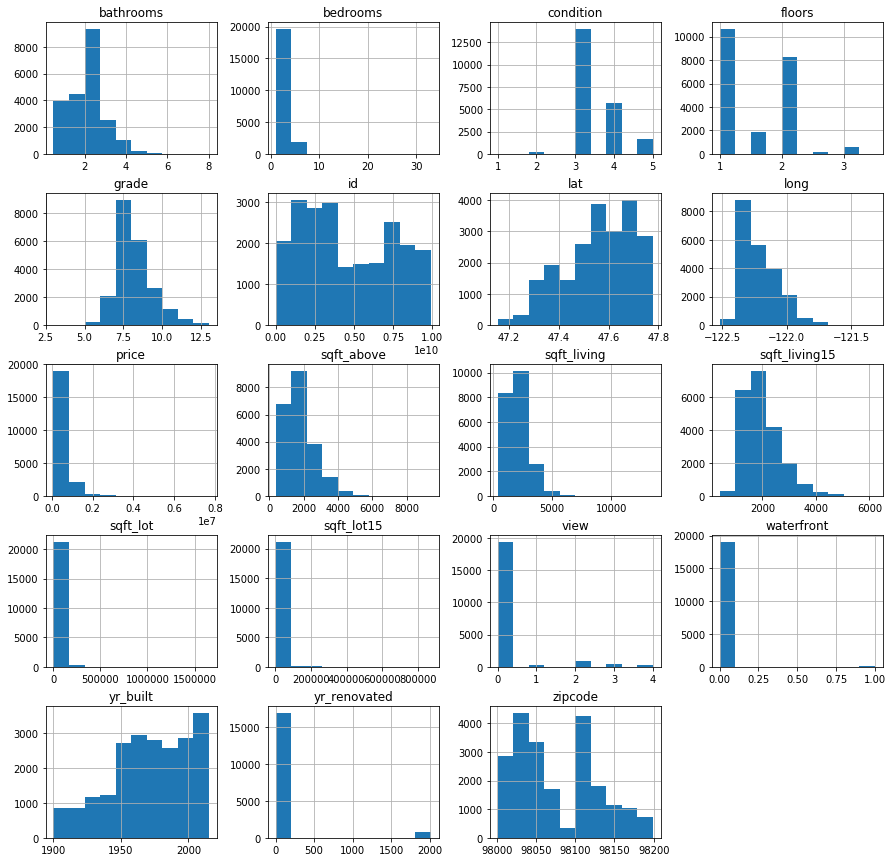

In [4]:
df.hist(figsize=(15,15));

---

## Data Cleaning

In [5]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [6]:
# waterfront, view, and yr_renovated have null values
# will look into that deeper to decide how to deal with them
# yr_renovated has a lot of missing values represented with a placeholder

In [7]:
# replace NaNs with 0
df['yr_renovated'] = df['yr_renovated'].fillna(0)

In [8]:
# make column renovated categorical, 1=renovated 0=not renovated
#drop yr_renovated column
df['renovated']=df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
df = df.drop(['yr_renovated'], axis=1)

In [9]:
df['renovated'].value_counts()

0    20853
1      744
Name: renovated, dtype: int64

In [10]:
# replace NaN values in "waterfront" with 0
df['waterfront'] = df['waterfront'].fillna(0)

In [11]:
# I will replace NaN values in "view" with 0
df['view'] = df['view'].fillna(0)

In [12]:
#one last check
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
renovated        0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
renovated        21597 non-null int64
dtypes: float64(7), int64(12), object(2)
memory usage: 3.5+ MB


In [14]:
df.sqft_basement.value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

In [15]:
#replaced '?' values with difference in sqft_living and sqft_above
df.loc[df['sqft_basement'] == '?', 'sqft_basement'] = df['sqft_living'] - df['sqft_above']

In [16]:
#deal with object types in order to plot heatmap
df['sqft_basement'] = df['sqft_basement'].map(float)

In [17]:
#drop 'id' and 'date' column because it is not a predictor
#drop lat and long 
df = df.drop(df[['id', 'date', 'lat', 'long']], axis=1)

In [18]:
#change yr_built column to age of house column
df['age'] = df['yr_built'].apply(lambda x: 2019 - x)
df = df.drop(['yr_built'], axis=1)

In [19]:
#transform categorical column 'renovated'
renovated_dummies = pd.get_dummies(df["renovated"], 
                                   prefix="renovated", 
                                   drop_first=True)
df = df.drop(["renovated"], axis=1)
df = pd.concat([df, renovated_dummies], axis=1)

In [20]:
#transform categorical column 'waterfront'
waterfront_dummies = pd.get_dummies(df["waterfront"], 
                                    prefix="waterfront", 
                                    drop_first=True)
df = df.drop(["waterfront"], axis=1)
df = pd.concat([df, waterfront_dummies], axis=1)

---

## Multicollinearity Check

**Correlation with an absolute value around 0.7-0.8 or higher is considered a high correlation. <br/>
I will remove independant variables that are highly correlated with each other.**

In [21]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,age,renovated_1,waterfront_1.0
price,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.393497,0.036056,0.667951,0.605368,0.323799,-0.053402,0.585241,0.082845,-0.053953,0.117543,0.264306
bedrooms,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.078354,0.026496,0.356563,0.479386,0.302808,-0.154092,0.393406,0.030690,-0.155670,0.017635,-0.002127
bathrooms,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.186016,-0.126479,0.665838,0.686668,0.283440,-0.204786,0.569884,0.088303,-0.507173,0.046742,0.063629
sqft_living,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.281715,-0.059445,0.762779,0.876448,0.435130,-0.199802,0.756402,0.184342,-0.318152,0.050829,0.104637
sqft_lot,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.075054,-0.008830,0.114731,0.184139,0.015418,-0.129586,0.144763,0.718204,-0.052946,0.005091,0.021459
floors,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.028414,-0.264075,0.458794,0.523989,-0.245715,-0.059541,0.280102,-0.010722,-0.489193,0.003713,0.020797
view,0.393497,0.078354,0.186016,0.281715,0.075054,0.028414,1.000000,0.045622,0.249082,0.166017,0.273845,0.085059,0.278928,0.073083,0.054452,0.090480,0.380543
condition,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.045622,1.000000,-0.146896,-0.158904,0.173849,0.002888,-0.093072,-0.003126,0.361592,-0.055383,0.016648
grade,0.667951,0.356563,0.665838,0.762779,0.114731,0.458794,0.249082,-0.146896,1.000000,0.756073,0.168220,-0.185771,0.713867,0.120981,-0.447865,0.015259,0.082818
sqft_above,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,0.166017,-0.158904,0.756073,1.000000,-0.052156,-0.261570,0.731767,0.195077,-0.424037,0.020566,0.071778


In [22]:
#check to see which independant variables have corraletion greater than 0.75
abs(df.corr()) > 0.75

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,age,renovated_1,waterfront_1.0
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
grade,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False
sqft_above,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False


**Independant Variables Highly Correlated with each other** <br/>
bathrooms - sqft_living <br/>
sqft_living - grade & sqft_above & sqft_living15 <br/>
grade - sqft_above <br/>
sqft_above - sqft_living & grade <br/>
sqft_living15 - sqft_living

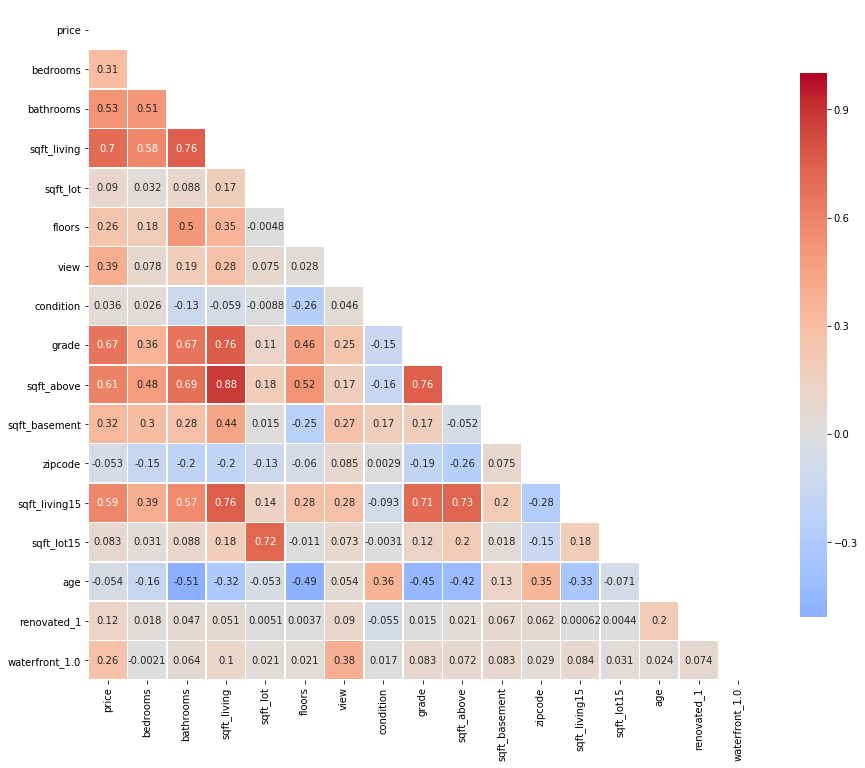

In [23]:
#visualize correlation using heatmap
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5});

In [24]:
predictors = ['bedrooms', 'bathrooms', 'sqft_living', 
              'sqft_lot', 'floors', 'waterfront_1.0', 
              'view', 'grade', 'sqft_basement', 
              'sqft_living15', 'sqft_lot15', 'renovated_1']
df_1 = df[predictors]

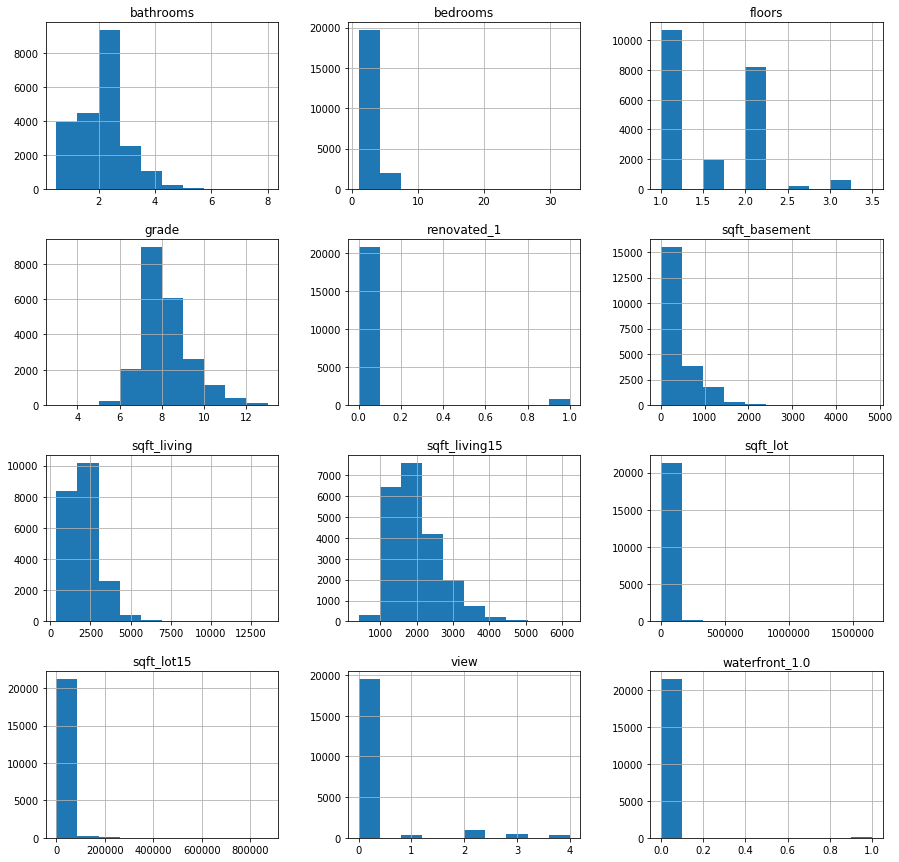

In [25]:
#let's take a look of distributions of selected predictors after preliminary data cleaning
df_1.hist(figsize=(15,15));

**Looks like there is skewness and variance in magnitude of the independent variables.** <br/>
**I will perform feature scaling and normalization.**

---

## Log Transformations

In [26]:
df_1.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront_1.0', 'view', 'grade', 'sqft_basement', 'sqft_living15',
       'sqft_lot15', 'renovated_1'],
      dtype='object')

In [30]:
df_log = pd.DataFrame([])
df_log['bathrooms'] = np.log(df_1['bathrooms'])
df_log['bedrooms'] = np.log(df_1['bedrooms'])
df_log['sqft_living'] = np.log(df_1['sqft_living'])
df_log['sqft_lot'] = np.log(df_1['sqft_lot'])
df_log['sqft_living15'] = np.log(df_1['sqft_living15'])
df_log['sqft_lot15'] = np.log(df_1['sqft_lot15'])

#
df_log['sqft_basement'] = df_1['sqft_basement']
df_log['floors'] = df_1['floors']
df_log['view'] = df_1['view']

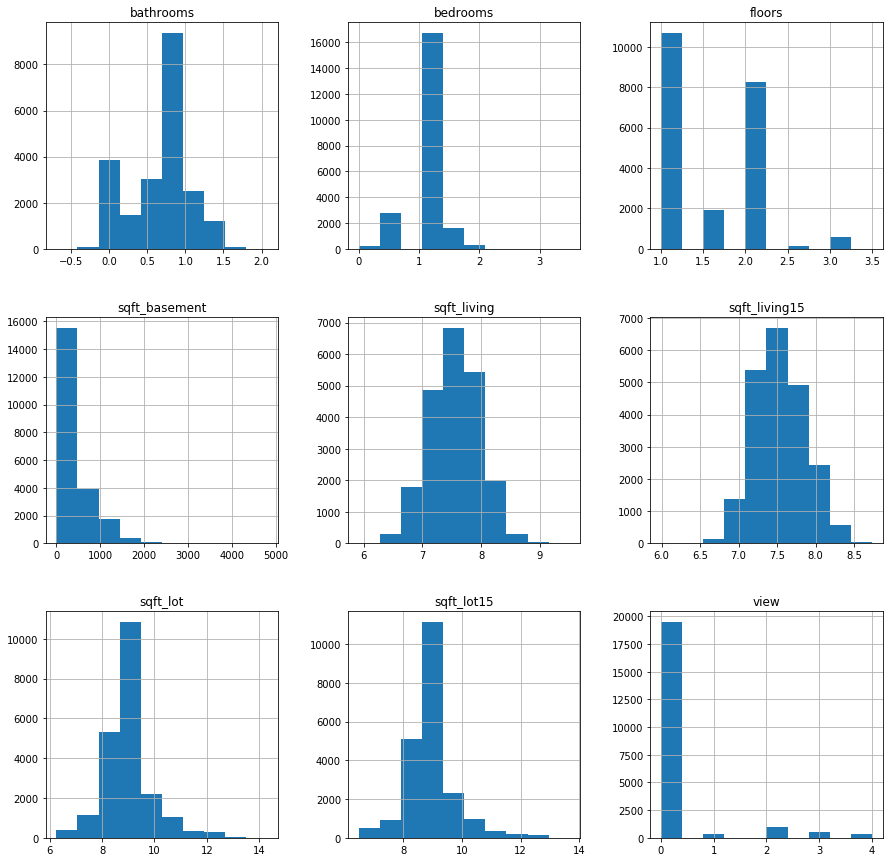

In [31]:
df_log.hist(figsize=(15,15));

---

**Linear Regression Assumption checks <br/>**
1. Linearity 
2. Normality (residuals)
3. Homoscedasticity

In [ ]:
df.columns

In [ ]:
#Using joint plots to check linearity and homoscedasticity
#will check normality of residuals after building model

predictors = ['bedrooms', 'bathrooms', 'sqft_living', 
              'sqft_lot', 'floors', 'waterfront_1.0', 
              'view', 'grade', 'sqft_basement', 
              'sqft_living15', 'sqft_lot15', 'renovated_1']

#plotting selected variables
for col in predictors:
    sns.jointplot(col,'price',data=df,kind='reg')
    plt.show()